### Juan Manuel Ramirez, Natalia Laiton y Laura Ortiz

In [ ]:
!pip install tensorflow_datasets

## Requisitos

In [ ]:
import matplotlib.pyplot as plt
import os
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

from IPython.display import clear_output

In [ ]:
EPOCHS = 100
PATIENCE = 20
HEIGTH = 128
WIDTH = 128

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0UPFFA/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0UPFFA/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

def load_image(example):
    input_image = tf.image.resize(example['image'], (128, 128))
    input_mask = tf.image.resize(example['segmentation_mask'], (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = int(TRAIN_LENGTH*.8) // BATCH_SIZE

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE).take(int(TRAIN_LENGTH*.8))
val_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE).skip(int(TRAIN_LENGTH*.8))

test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_images = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_images = val_images.batch(BATCH_SIZE)
test_images = test_images.batch(BATCH_SIZE)

In [ ]:
train_images

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>

## Exploracion de datos

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
        plt.show()

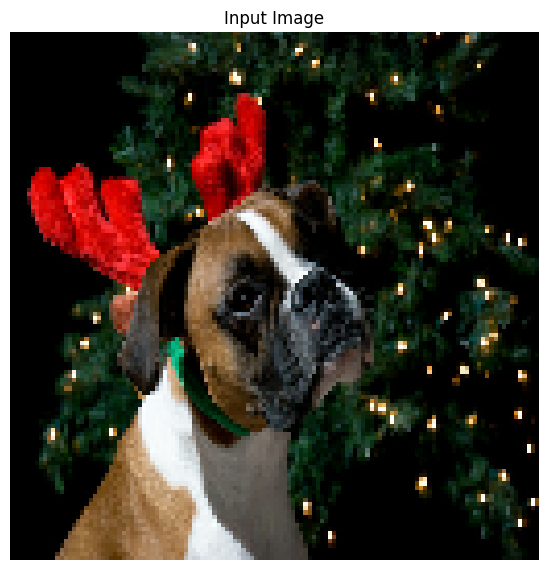

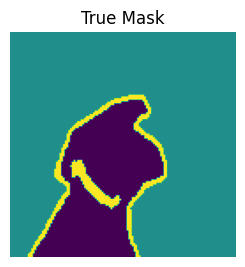

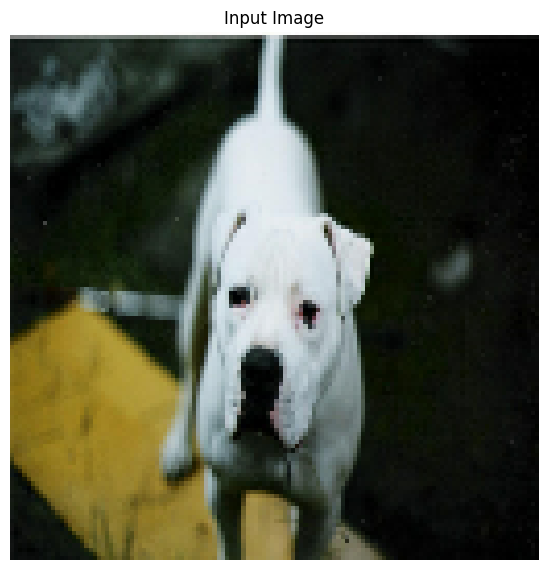

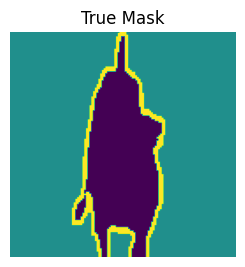

In [ ]:
for images, masks in train_images.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## Modelo base

In [ ]:
image_input = tf.keras.layers.Input((HEIGTH, WIDTH, 3), dtype=tf.float32, name="INPUT_IMAGE")

# Encoder

augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=42)(image_input)
augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=42)(image_input)

conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="SAME", activation="relu")(augment_inputs)
down_sampling_64 = tf.keras.layers.MaxPool2D(2, name="down_64")(conv_1)

conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="SAME", activation="relu")(down_sampling_64)
down_sampling_32 = tf.keras.layers.MaxPool2D(2, name="down_32")(conv_2)

conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="SAME", activation="relu")(down_sampling_32)
down_sampling_16 = tf.keras.layers.MaxPool2D(2, name="down_16")(conv_3)

conv_4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="SAME", activation="relu")(down_sampling_16)
down_sampling_8 = tf.keras.layers.MaxPool2D(2, name="down_8")(conv_4)

conv_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="SAME", activation="relu")(down_sampling_8)
down_sampling_4 = tf.keras.layers.MaxPool2D(2, name="down_4")(conv_5)

# Decoder

upsampling_8 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding="SAME", activation="relu")(down_sampling_4)
upsampling_8 = tf.keras.layers.Concatenate()([down_sampling_8, upsampling_8])

upsampling_16 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_8)
upsampling_16 = tf.keras.layers.Concatenate()([down_sampling_16, upsampling_16])

upsampling_32 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_16)
upsampling_32 = tf.keras.layers.Concatenate()([down_sampling_32, upsampling_32])

upsampling_64 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_32)
upsampling_64 = tf.keras.layers.Concatenate()([down_sampling_64, upsampling_64])

upsampling_128 = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_64)

model = tf.keras.Model(inputs=[image_input], outputs=[upsampling_128], name="model")

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT_IMAGE (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 random_flip_5 (RandomFlip)  (None, 128, 128, 3)          0         ['INPUT_IMAGE[0][0]']         
                                                                                                  
 conv2d_5 (Conv2D)           (None, 128, 128, 32)         896       ['random_flip_5[0][0]']       
                                                                                                  
 down_64 (MaxPooling2D)      (None, 64, 64, 32)           0         ['conv2d_5[0][0]']            
                                                                                              

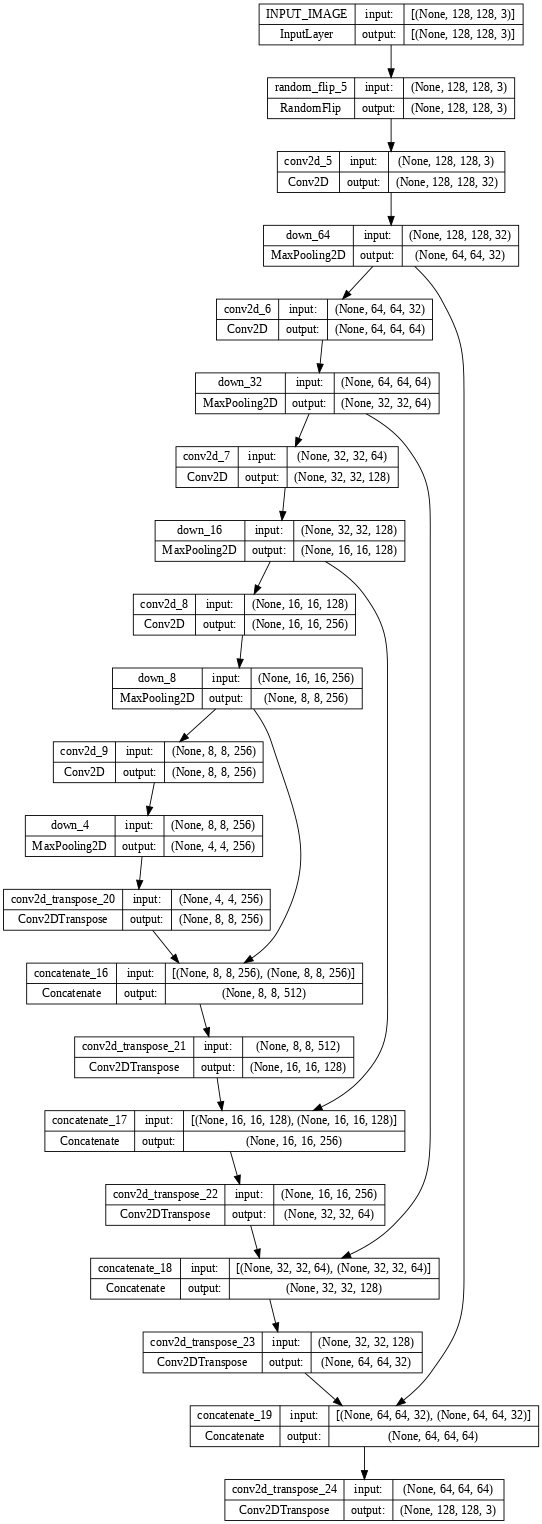

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 0s 215ms/step


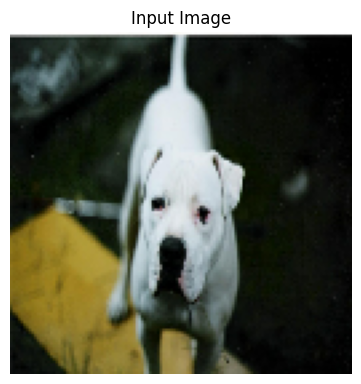

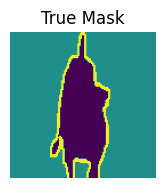

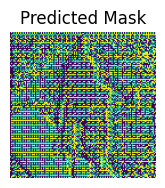

In [ ]:
show_predictions()

In [ ]:
import time
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):

        clear_output(wait=True)
        show_predictions()
        time.sleep(3)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

1/1 [==============================] - 0s 20ms/step


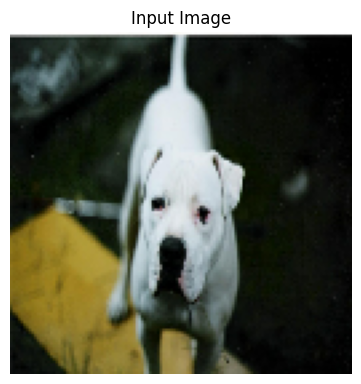

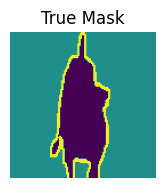

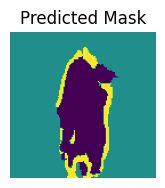


Sample Prediction after epoch 35

46/46 [==============================] - 17s 374ms/step - loss: 0.4729 - accuracy: 0.8134 - val_loss: 0.5305 - val_accuracy: 0.7866


In [ ]:
EPOCHS = 50
VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
VALIDATION_STEPS = int(TRAIN_LENGTH*.2)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(
    train_images,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_images,
    callbacks=[DisplayCallback(), early_stopping]
)

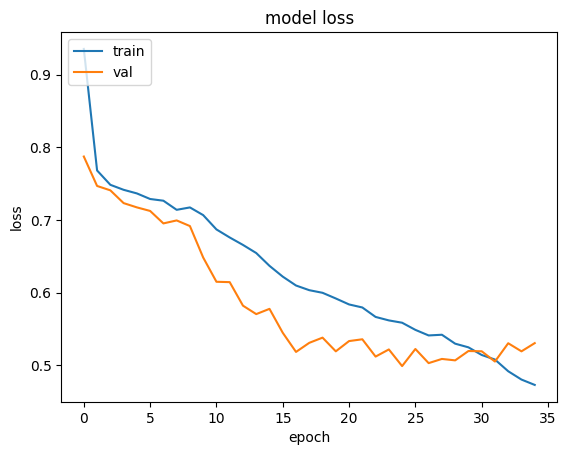

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_images)

58/58 [==============================] - 11s 183ms/step - loss: 0.5048 - accuracy: 0.7943


[0.5048349499702454, 0.7942632436752319]

## 1. Mitigar Overfitting

### Reducción de parámetros

In [ ]:
# Modelo2
image_input = tf.keras.layers.Input((HEIGTH, WIDTH, 3), dtype=tf.float32, name="INPUT_IMAGE")

# Encoder
augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=42)(image_input)

conv_1 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding="SAME", activation="relu", name="conv_1")(augment_inputs)
down_sampling_64 = tf.keras.layers.MaxPool2D(2, name="down_64")(conv_1)

conv_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="SAME", activation="relu", name="conv_2")(down_sampling_64)
down_sampling_32 = tf.keras.layers.MaxPool2D(2, name="down_32")(conv_2)

conv_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="SAME", activation="relu", name="conv_3")(down_sampling_32)
down_sampling_16 = tf.keras.layers.MaxPool2D(2, name="down_16")(conv_3)

conv_4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="SAME", activation="relu", name="conv_4")(down_sampling_16)
down_sampling_8 = tf.keras.layers.MaxPool2D(2, name="down_8")(conv_4)

conv_5 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="SAME", activation="relu", name="conv_5")(down_sampling_8)
down_sampling_4 = tf.keras.layers.MaxPool2D(2, name="down_4")(conv_5)

# Decoder
upsampling_8 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="SAME", activation="relu")(down_sampling_4)
upsampling_8 = tf.keras.layers.Concatenate()([down_sampling_8, conv_5])

upsampling_16 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_8)
upsampling_16 = tf.keras.layers.Concatenate()([upsampling_16, conv_4])

upsampling_32 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_16)
upsampling_32 = tf.keras.layers.Concatenate()([upsampling_32, conv_3])

upsampling_64 = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_32)
upsampling_64 = tf.keras.layers.Concatenate()([upsampling_64, conv_2])

upsampling_128 = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_64)

model2 = tf.keras.Model(inputs=[image_input], outputs=[upsampling_128], name="model2")

In [ ]:
model2.summary()

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT_IMAGE (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 random_flip_10 (RandomFlip  (None, 128, 128, 3)          0         ['INPUT_IMAGE[0][0]']         
 )                                                                                                
                                                                                                  
 conv_1 (Conv2D)             (None, 128, 128, 8)          224       ['random_flip_10[0][0]']      
                                                                                                  
 down_64 (MaxPooling2D)      (None, 64, 64, 8)            0         ['conv_1[0][0]']         

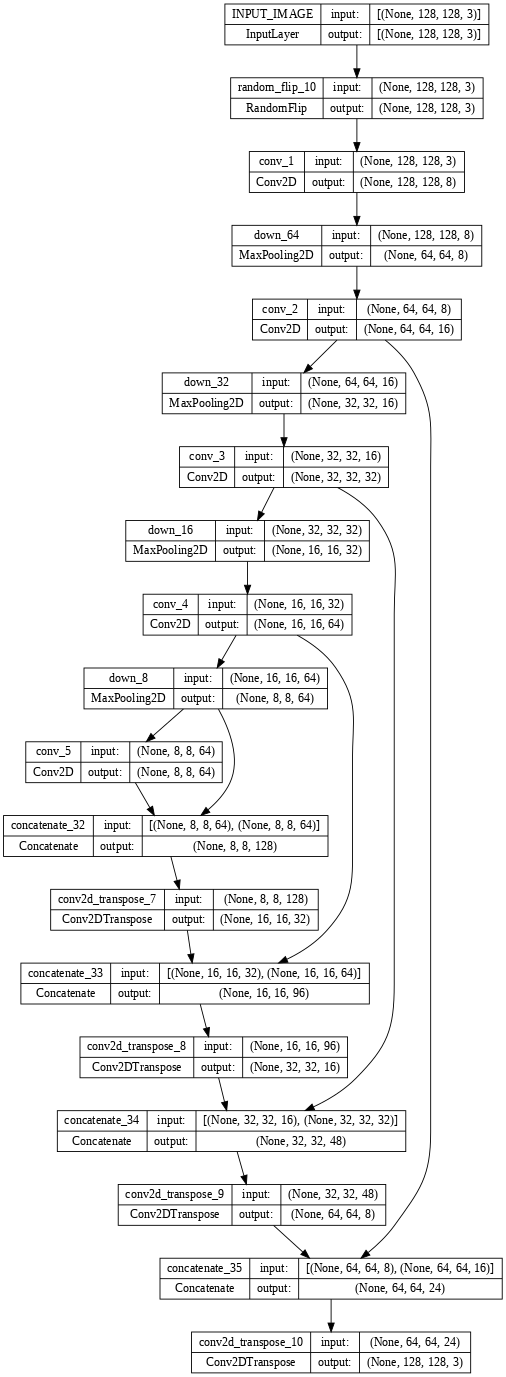

In [ ]:
tf.keras.utils.plot_model(model2, show_shapes=True, expand_nested=True, dpi=64)

### BatchNormalization

In [ ]:
# Modelo con BatchNormalization
image_input = tf.keras.layers.Input((HEIGTH, WIDTH, 3), dtype=tf.float32, name="INPUT_IMAGE")

# Encoder
augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=42)(image_input)

conv_1 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding="SAME", activation="relu", name="conv_1b")(augment_inputs)
conv_1 = tf.keras.layers.BatchNormalization()(conv_1)
down_sampling_64 = tf.keras.layers.MaxPool2D(2, name="down_64")(conv_1)

conv_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="SAME", activation="relu", name="conv_2b")(down_sampling_64)
conv_2 = tf.keras.layers.BatchNormalization()(conv_2)
down_sampling_32 = tf.keras.layers.MaxPool2D(2, name="down_32")(conv_2)

conv_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="SAME", activation="relu", name="conv_3b")(down_sampling_32)
conv_3 = tf.keras.layers.BatchNormalization()(conv_3)
down_sampling_16 = tf.keras.layers.MaxPool2D(2, name="down_16")(conv_3)

conv_4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="SAME", activation="relu", name="conv_4b")(down_sampling_16)
conv_4 = tf.keras.layers.BatchNormalization()(conv_4)
down_sampling_8 = tf.keras.layers.MaxPool2D(2, name="down_8")(conv_4)

conv_5 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="SAME", activation="relu", name="conv_5b")(down_sampling_8)
conv_5 = tf.keras.layers.BatchNormalization()(conv_5)
down_sampling_4 = tf.keras.layers.MaxPool2D(2, name="down_4")(conv_5)

# Decoder
upsampling_8 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="SAME", activation="relu")(down_sampling_4)
upsampling_8 = tf.keras.layers.Concatenate()([upsampling_8, conv_5])

upsampling_16 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_8)
upsampling_16 = tf.keras.layers.Concatenate()([upsampling_16, conv_4])

upsampling_32 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_16)
upsampling_32 = tf.keras.layers.Concatenate()([upsampling_32, conv_3])

upsampling_64 = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_32)
upsampling_64 = tf.keras.layers.Concatenate()([upsampling_64, conv_2])

upsampling_128 = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_64)

model3 = tf.keras.Model(inputs=[image_input], outputs=[upsampling_128], name="model3")

In [ ]:
model3.summary()

Model: "model3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT_IMAGE (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 random_flip_8 (RandomFlip)  (None, 128, 128, 3)          0         ['INPUT_IMAGE[0][0]']         
                                                                                                  
 conv_1b (Conv2D)            (None, 128, 128, 8)          224       ['random_flip_8[0][0]']       
                                                                                                  
 batch_normalization_5 (Bat  (None, 128, 128, 8)          32        ['conv_1b[0][0]']             
 chNormalization)                                                                            

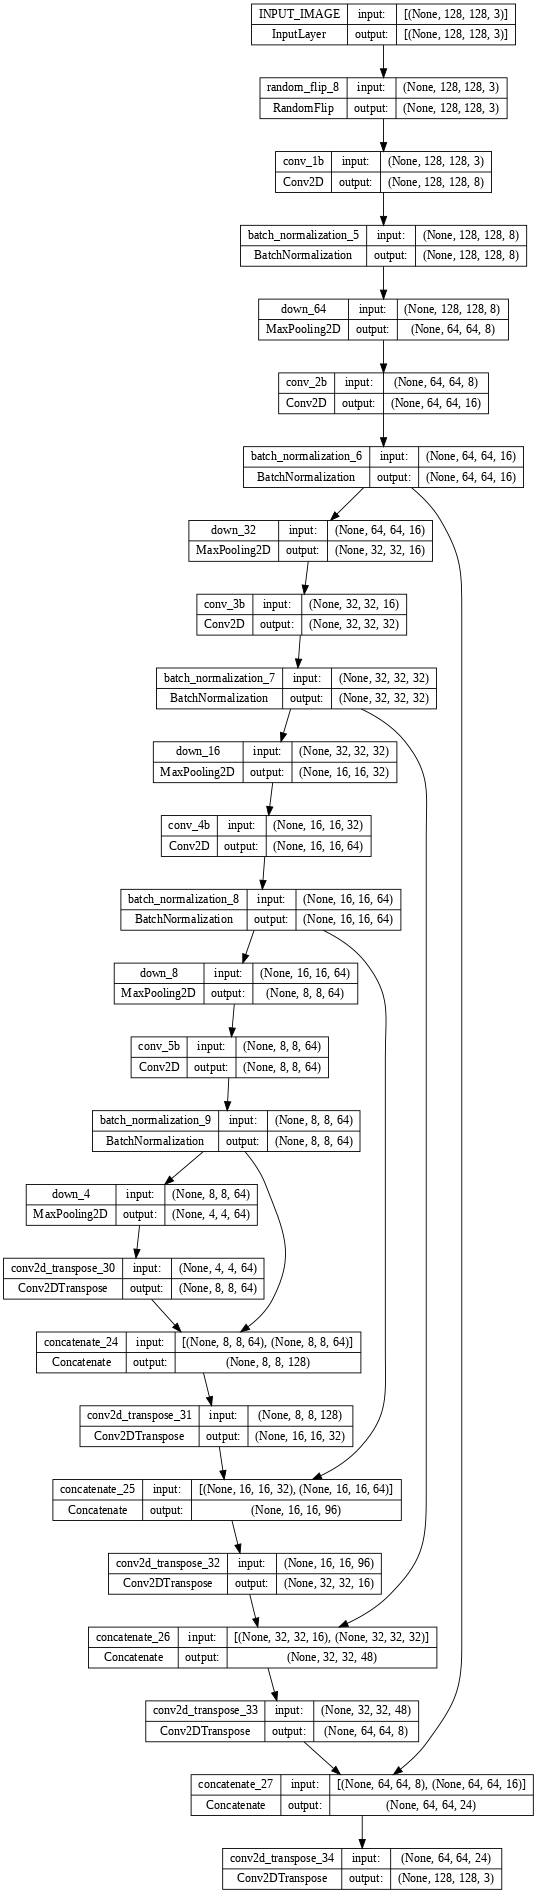

In [ ]:
tf.keras.utils.plot_model(model3, show_shapes=True, expand_nested=True, dpi=64)

### Dropout

In [ ]:
# Modelo con Dropout
image_input = tf.keras.layers.Input((HEIGTH, WIDTH, 3), dtype=tf.float32, name="INPUT_IMAGE")

# Encoder
augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=42)(image_input)

conv_1 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding="SAME", activation="relu", name="conv_1b")(augment_inputs)
conv_1 = tf.keras.layers.Dropout(0.1)(conv_1)
down_sampling_64 = tf.keras.layers.MaxPool2D(2, name="down_64")(conv_1)

conv_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="SAME", activation="relu", name="conv_2b")(down_sampling_64)
conv_2 = tf.keras.layers.Dropout(0.1)(conv_2)
down_sampling_32 = tf.keras.layers.MaxPool2D(2, name="down_32")(conv_2)

conv_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="SAME", activation="relu", name="conv_3b")(down_sampling_32)
conv_3 = tf.keras.layers.Dropout(0.1)(conv_3)
down_sampling_16 = tf.keras.layers.MaxPool2D(2, name="down_16")(conv_3)

conv_4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="SAME", activation="relu", name="conv_4b")(down_sampling_16)
conv_4 = tf.keras.layers.Dropout(0.1)(conv_4)
down_sampling_8 = tf.keras.layers.MaxPool2D(2, name="down_8")(conv_4)

conv_5 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="SAME", activation="relu", name="conv_5b")(down_sampling_8)
conv_5 = tf.keras.layers.Dropout(0.1)(conv_5)
down_sampling_4 = tf.keras.layers.MaxPool2D(2, name="down_4")(conv_5)

# Decoder
upsampling_8 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="SAME", activation="relu")(down_sampling_4)
upsampling_8 = tf.keras.layers.Concatenate()([upsampling_8, conv_5])

upsampling_16 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_8)
upsampling_16 = tf.keras.layers.Concatenate()([upsampling_16, conv_4])

upsampling_32 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_16)
upsampling_32 = tf.keras.layers.Concatenate()([upsampling_32, conv_3])

upsampling_64 = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_32)
upsampling_64 = tf.keras.layers.Concatenate()([upsampling_64, conv_2])

upsampling_128 = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_64)

model4 = tf.keras.Model(inputs=[image_input], outputs=[upsampling_128], name="model4")

In [ ]:
model4.summary()

Model: "model4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT_IMAGE (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 random_flip_9 (RandomFlip)  (None, 128, 128, 3)          0         ['INPUT_IMAGE[0][0]']         
                                                                                                  
 conv_1b (Conv2D)            (None, 128, 128, 8)          224       ['random_flip_9[0][0]']       
                                                                                                  
 dropout_5 (Dropout)         (None, 128, 128, 8)          0         ['conv_1b[0][0]']             
                                                                                             

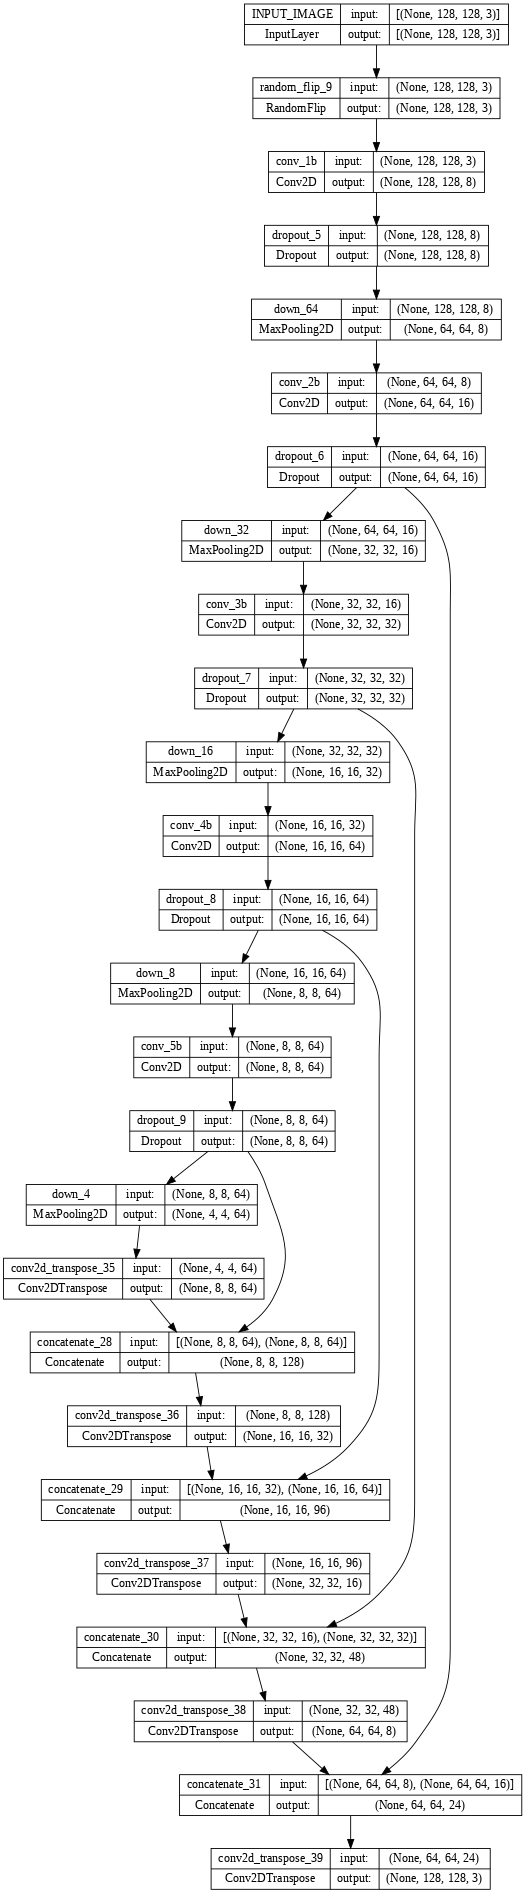

In [ ]:
tf.keras.utils.plot_model(model4, show_shapes=True, expand_nested=True, dpi=64)

### Procesamiento de modelos

In [ ]:
model2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model3.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model4.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):

        clear_output(wait=True)
        show_predictions()
        time.sleep(3)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
EPOCHS = 50
VAL_SUBSPLITS = 5
#VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
VALIDATION_STEPS = int(TRAIN_LENGTH*.8)//BATCH_SIZE//VAL_SUBSPLITS

1/1 [==============================] - 0s 20ms/step


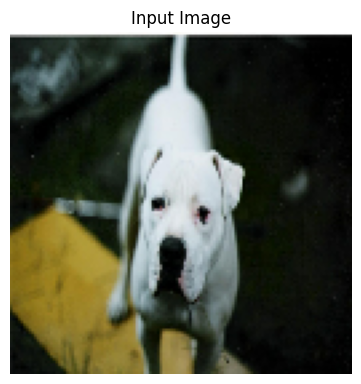

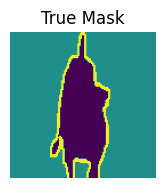

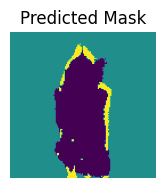


Sample Prediction after epoch 50

46/46 [==============================] - 15s 333ms/step - loss: 0.6267 - accuracy: 0.7546 - val_loss: 0.5612 - val_accuracy: 0.7806


In [ ]:
model_history2 = model2.fit(
    train_images,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_images,
    callbacks=[DisplayCallback(), early_stopping]
)

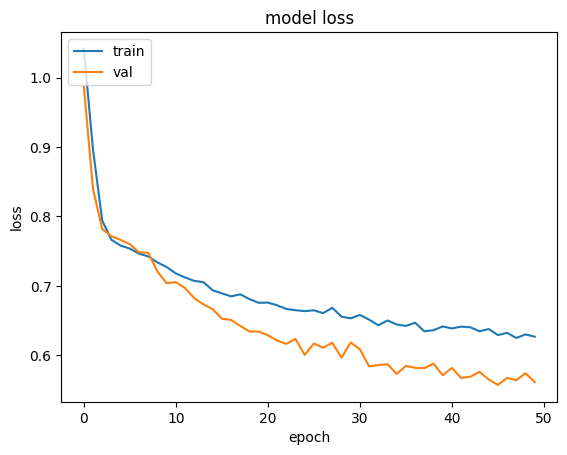

In [ ]:
plt.plot(model_history2.history['loss'])
plt.plot(model_history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model2.evaluate(test_images)

58/58 [==============================] - 10s 174ms/step - loss: 0.5616 - accuracy: 0.7775


[0.5615805387496948, 0.7775321006774902]

1/1 [==============================] - 0s 19ms/step


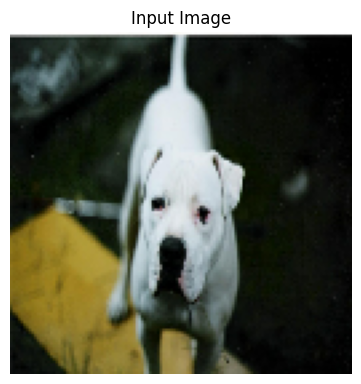

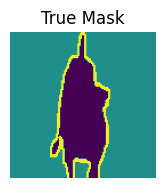

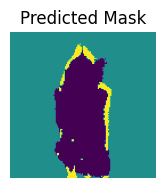


Sample Prediction after epoch 28

46/46 [==============================] - 12s 275ms/step - loss: 0.5307 - accuracy: 0.7921 - val_loss: 0.5936 - val_accuracy: 0.7710


In [ ]:
model_history3 = model3.fit(
    train_images,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_images,
    callbacks=[DisplayCallback(), early_stopping]
)

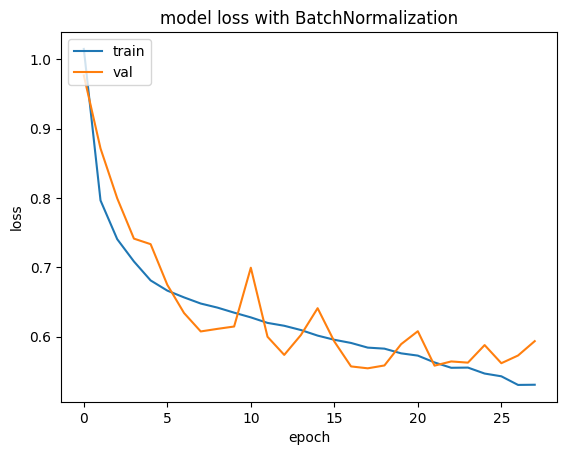

In [ ]:
plt.plot(model_history3.history['loss'])
plt.plot(model_history3.history['val_loss'])
plt.title('model loss with BatchNormalization')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model3.evaluate(test_images)

58/58 [==============================] - 10s 176ms/step - loss: 0.5673 - accuracy: 0.7725


[0.5672503113746643, 0.7724828720092773]

1/1 [==============================] - 0s 18ms/step


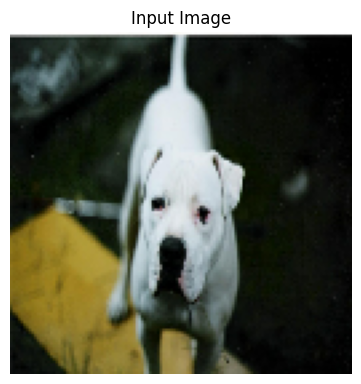

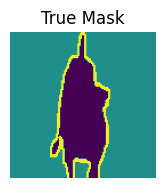

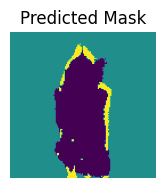


Sample Prediction after epoch 50

46/46 [==============================] - 16s 344ms/step - loss: 0.5925 - accuracy: 0.7661 - val_loss: 0.5450 - val_accuracy: 0.7851


In [ ]:
model_history4 = model4.fit(
    train_images,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_images,
    callbacks=[DisplayCallback(), early_stopping]
)

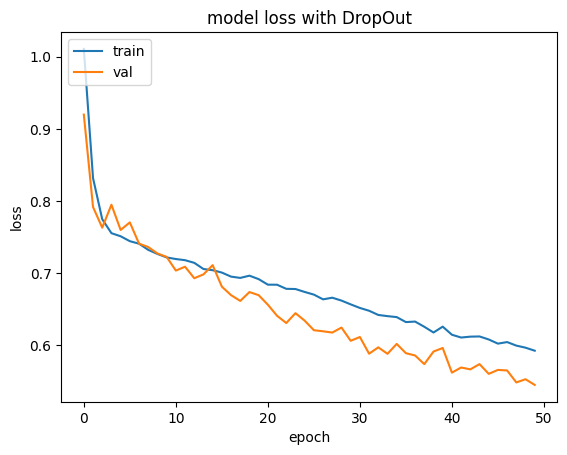

In [ ]:
plt.plot(model_history4.history['loss'])
plt.plot(model_history4.history['val_loss'])
plt.title('model loss with DropOut')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model4.evaluate(test_images)

58/58 [==============================] - 9s 154ms/step - loss: 0.5525 - accuracy: 0.7790


[0.5524770021438599, 0.7790007591247559]

## 2. Reproducir análisis del gato

En nuestro caso nuestro mejor modelo al final fue solo reduciendo parámetros, por lo tanto el análisis del gato lo haremos con el modelo 2

In [ ]:
conv_1 = model2.get_layer("conv_1")
conv_2 = model2.get_layer("conv_2")
conv_3 = model2.get_layer("conv_3")
conv_4 = model2.get_layer("conv_4")
conv_5 = model2.get_layer("conv_5")

conv_6 = model2.get_layer("conv2d_transpose_41")
conv_7 = model2.get_layer("conv2d_transpose_42")
conv_8 = model2.get_layer("conv2d_transpose_43")
conv_9 = model2.get_layer("conv2d_transpose_44")

intermediate_models = []
for conv_layer in (conv_1, conv_2, conv_3, conv_4, conv_5, conv_6, conv_7, conv_8, conv_9):
    intermediate_model = tf.keras.Model(
        inputs=model2.input,
        outputs=conv_layer.output
    )
    intermediate_models.append(intermediate_model)

intermediate_models

In [ ]:
skip = np.random.randint(0, TRAIN_LENGTH, ())
test_example = train_images.unbatch().batch(1).skip(skip).take(1)
for images in test_example:
    test_image = images[0]
    test_image_label = images[1]

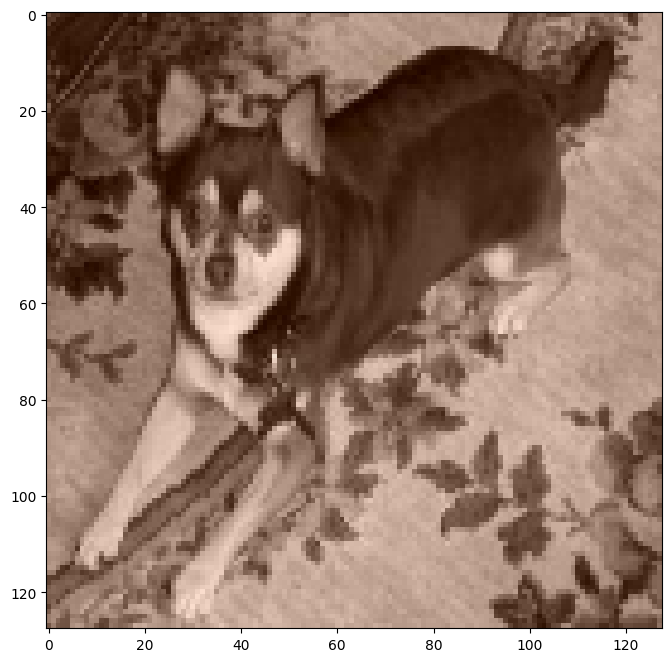

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(np.squeeze(test_image), aspect="equal", interpolation='nearest')

1/1 [==============================] - 0s 84ms/step


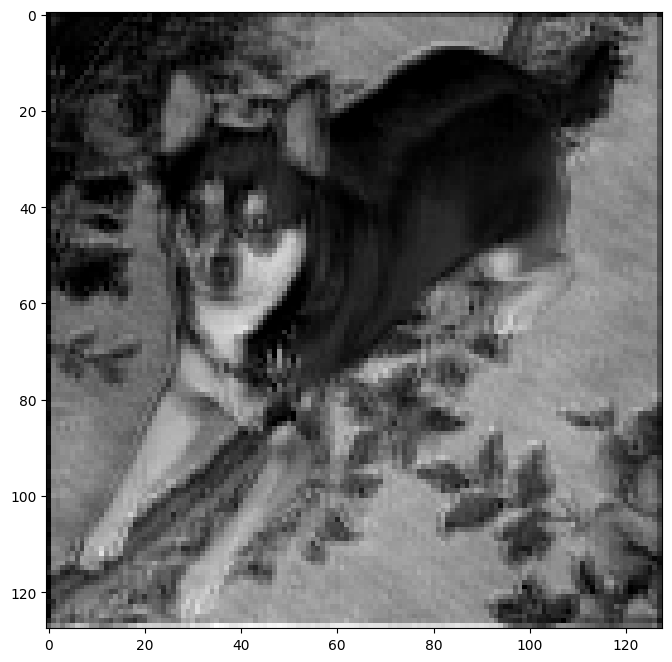

In [ ]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[0].layers[-1].filters, ())
plt.imshow(intermediate_models[0].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

1/1 [==============================] - 0s 152ms/step


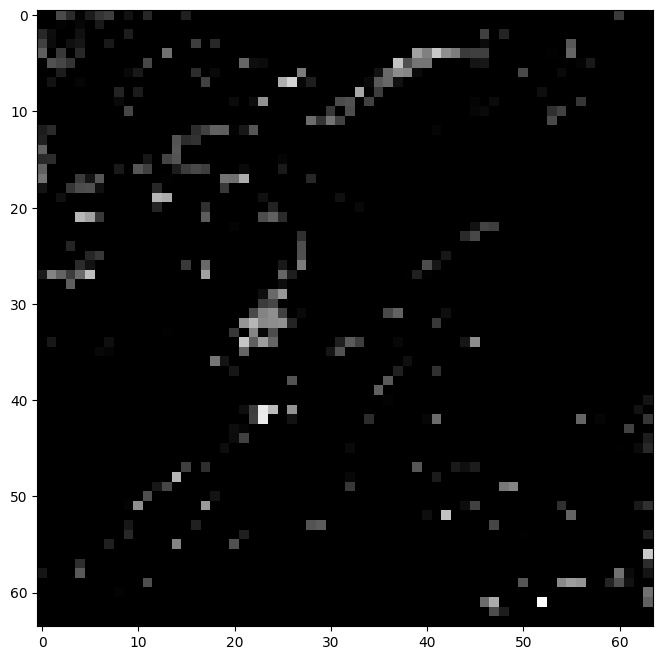

In [ ]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[1].layers[-1].filters, ())
plt.imshow(intermediate_models[1].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

1/1 [==============================] - 0s 189ms/step


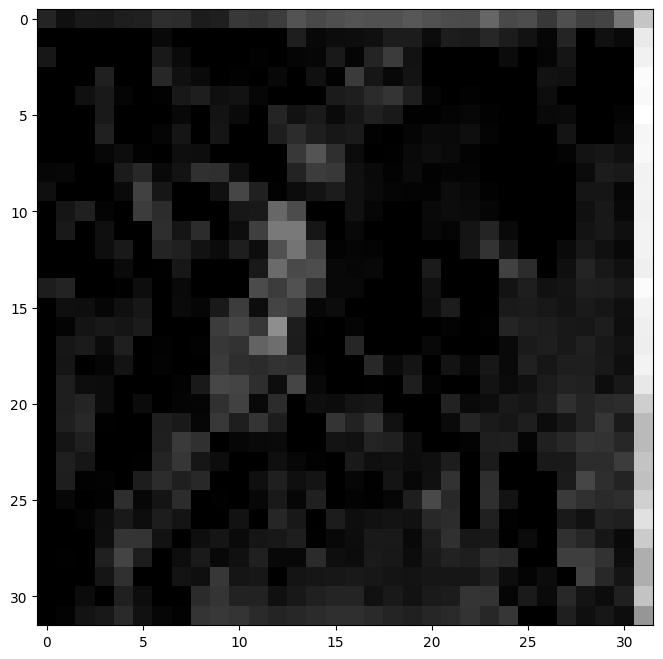

In [ ]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[2].layers[-1].filters, ())
plt.imshow(intermediate_models[2].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

1/1 [==============================] - 0s 181ms/step


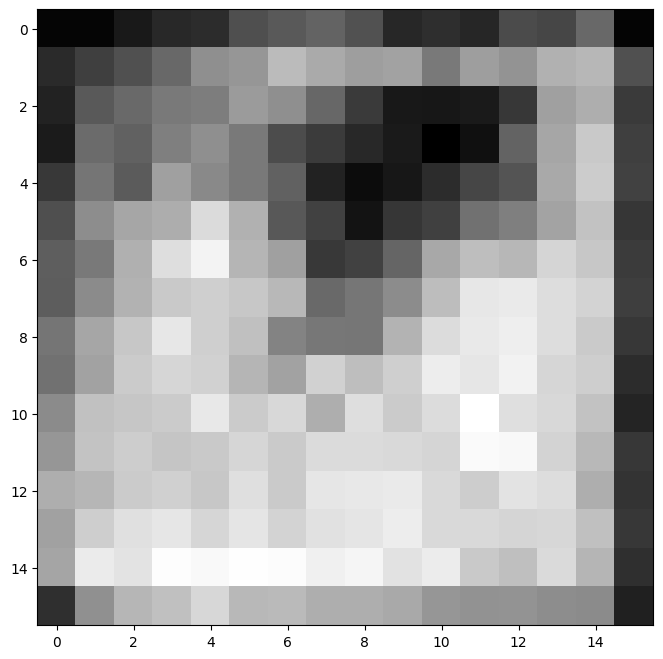

In [ ]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[3].layers[-1].filters, ())
plt.imshow(intermediate_models[3].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

1/1 [==============================] - 0s 191ms/step


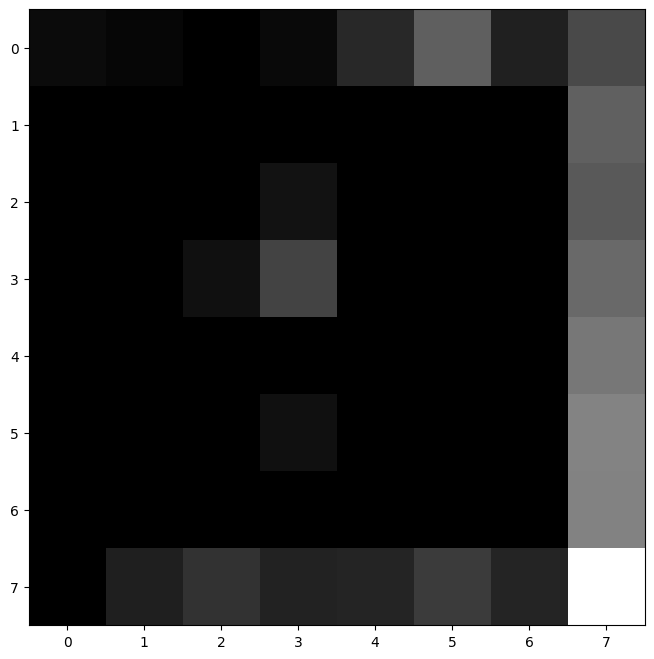

In [ ]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[4].layers[-1].filters, ())
plt.imshow(intermediate_models[4].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

1/1 [==============================] - 0s 169ms/step


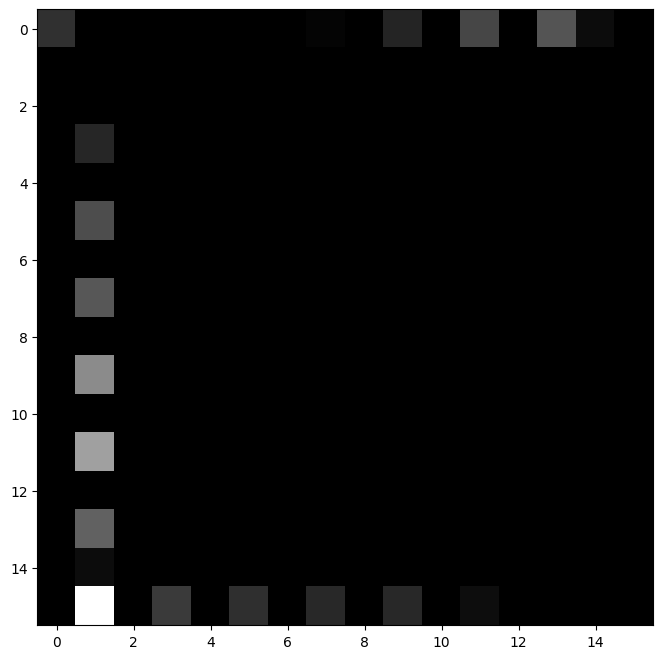

In [ ]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[5].layers[-1].filters, ())
plt.imshow(intermediate_models[5].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

1/1 [==============================] - 0s 141ms/step


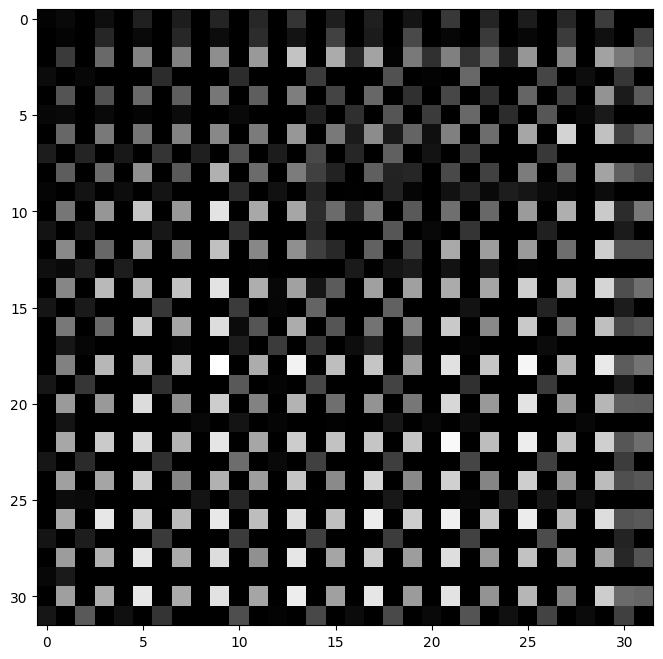

In [ ]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[6].layers[-1].filters, ())
plt.imshow(intermediate_models[6].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

1/1 [==============================] - 0s 172ms/step


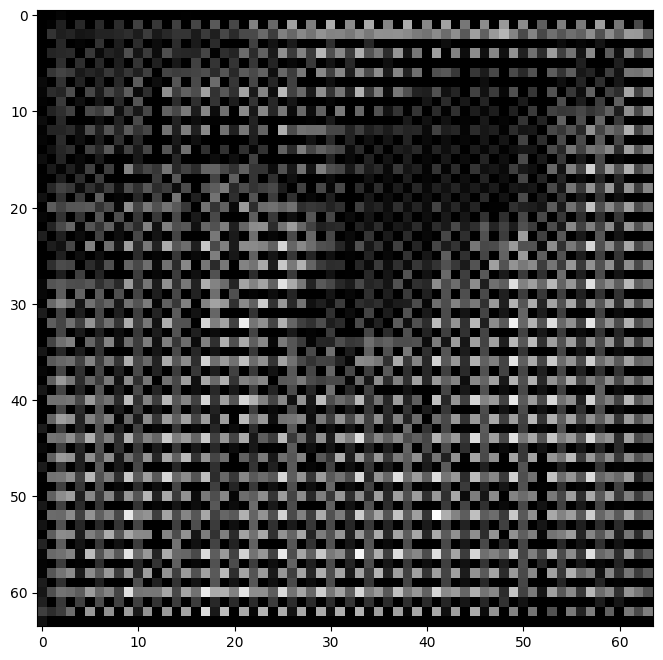

In [ ]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[7].layers[-1].filters, ())
plt.imshow(intermediate_models[7].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

1/1 [==============================] - 0s 186ms/step


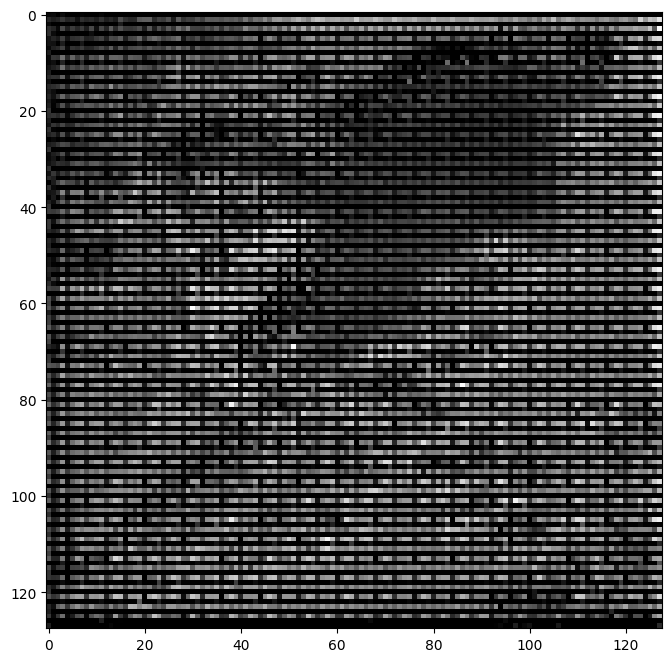

In [ ]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[8].layers[-1].filters, ())
plt.imshow(intermediate_models[8].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

## 3. Pesos de clases

In [ ]:
# Modelo cambiando pesos
image_input = tf.keras.layers.Input((HEIGTH, WIDTH, 3), dtype=tf.float32, name="INPUT_IMAGE")

# Encoder
augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=42)(image_input)

conv_1 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, padding="SAME", activation="relu", name="conv_1")(augment_inputs)
down_sampling_64 = tf.keras.layers.MaxPool2D(2, name="down_64")(conv_1)

conv_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="SAME", activation="relu", name="conv_2")(down_sampling_64)
down_sampling_32 = tf.keras.layers.MaxPool2D(2, name="down_32")(conv_2)

conv_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="SAME", activation="relu", name="conv_3")(down_sampling_32)
down_sampling_16 = tf.keras.layers.MaxPool2D(2, name="down_16")(conv_3)

conv_4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="SAME", activation="relu", name="conv_4")(down_sampling_16)
down_sampling_8 = tf.keras.layers.MaxPool2D(2, name="down_8")(conv_4)

conv_5 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="SAME", activation="relu", name="conv_5")(down_sampling_8)
down_sampling_4 = tf.keras.layers.MaxPool2D(2, name="down_4")(conv_5)

# Decoder
upsampling_8 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="SAME", activation="relu")(down_sampling_4)
upsampling_8 = tf.keras.layers.Concatenate()([down_sampling_8, conv_5])

upsampling_16 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_8)
upsampling_16 = tf.keras.layers.Concatenate()([upsampling_16, conv_4])

upsampling_32 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_16)
upsampling_32 = tf.keras.layers.Concatenate()([upsampling_32, conv_3])

upsampling_64 = tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_32)
upsampling_64 = tf.keras.layers.Concatenate()([upsampling_64, conv_2])

upsampling_128 = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding="SAME", activation="relu")(upsampling_64)

model5 = tf.keras.Model(inputs=[image_input], outputs=[upsampling_128], name="model22")

In [ ]:
model5.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
def add_sample_weights(image, label):

  class_weights = tf.constant([25.0, 100.0, 0.1]) # Objeto, borde, fondo
  class_weights = class_weights / tf.reduce_sum(class_weights)

  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

1/1 [==============================] - 0s 21ms/step


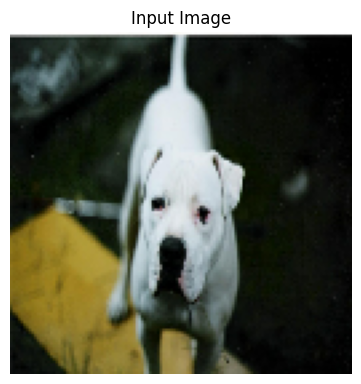

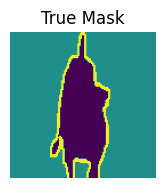

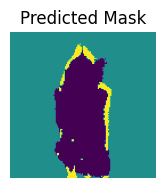


Sample Prediction after epoch 12

46/46 [==============================] - 5s 114ms/step - loss: 0.1573 - accuracy: 0.6203 - val_loss: 1.5577 - val_accuracy: 0.5951


In [ ]:
model_history5 = model5.fit(
    train_images.map(add_sample_weights),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_images,
    callbacks=[DisplayCallback(), early_stopping]
)

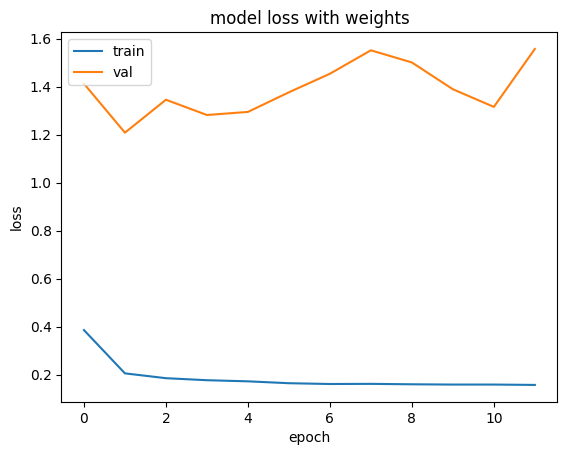

In [ ]:
plt.plot(model_history5.history['loss'])
plt.plot(model_history5.history['val_loss'])
plt.title('model loss with weights')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_images)

58/58 [==============================] - 13s 223ms/step - loss: 0.5048 - accuracy: 0.7943


[0.5048349499702454, 0.7942632436752319]

In [ ]:
model2.evaluate(test_images)

58/58 [==============================] - 10s 170ms/step - loss: 0.5616 - accuracy: 0.7775


[0.5615805387496948, 0.7775321006774902]

In [ ]:
model3.evaluate(test_images)

58/58 [==============================] - 10s 169ms/step - loss: 0.5673 - accuracy: 0.7725


[0.5672503113746643, 0.7724828720092773]

In [ ]:
model4.evaluate(test_images)

58/58 [==============================] - 10s 159ms/step - loss: 0.5525 - accuracy: 0.7790


[0.5524770021438599, 0.7790007591247559]

In [ ]:
model5.evaluate(test_images)

58/58 [==============================] - 9s 153ms/step - loss: 1.1716 - accuracy: 0.5772


[1.171649694442749, 0.5772286653518677]